Project 4 Beginning - Austin Hwang

In [1]:
import pandas as pd


In [2]:
# Load datasets
penetration_df = pd.read_csv("datasets/penetration.csv")  # Solar adoption per state
rate_df = pd.read_csv("datasets/rate.csv")  # Electricity rate per state
emission_df = pd.read_csv("datasets/emission.csv")  # Annual emissions per capita
wildfire_df = pd.read_csv("datasets/Wildfires_by_state_2023.csv")  # Wildfire incidents per state
outage_df = pd.read_csv("datasets/power-outages-by-state-2024.csv")  # Power outage data per state


In [3]:
# Standardizing column names
outage_df.rename(columns={"state": "State", "PowerOutages": "Power_Outage_Count"}, inplace=True)
wildfire_df.rename(columns={"Number of fires": "Wildfire_Count"}, inplace=True)
penetration_df.rename(columns={"State-level": "Solar_Adoption_Rate"}, inplace=True)
emission_df.rename(columns={"Annual_Emmision_percapita_MT": "Emissions_Per_Capita"}, inplace=True)
rate_df.rename(columns={"Price_Cents/kWh": "Electricity_Rate"}, inplace=True)


In [4]:
# Shorten state names
state_name_to_abbreviation = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'Washington DC': 'DC', 'Puerto Rico': 'PR'
}

In [5]:
# Apply state name conversion
for df in [penetration_df, rate_df, emission_df, wildfire_df, outage_df]:
    df['State'] = df['State'].replace(state_name_to_abbreviation)

In [6]:
# Merge all datasets on State
merged_df = (penetration_df
    .merge(wildfire_df, on="State", how="left")
    .merge(outage_df, on="State", how="left")
    .merge(rate_df, on="State", how="left")
    .merge(emission_df, on="State", how="left"))

In [7]:
# Convert to numeric
for col in ["Wildfire_Count", "Power_Outage_Count", "Electricity_Rate", "Emissions_Per_Capita", "Solar_Adoption_Rate"]:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').fillna(0)

In [8]:
# Normalize data by using Min-Max Scaling
merged_df["Wildfire_Norm"] = merged_df["Wildfire_Count"] / merged_df["Wildfire_Count"].max()
merged_df["Solar_Norm"] = merged_df["Solar_Adoption_Rate"] / merged_df["Solar_Adoption_Rate"].max()
merged_df["Emission_Norm"] = merged_df["Emissions_Per_Capita"] / merged_df["Emissions_Per_Capita"].max()


In [9]:
# for power outages data -> put 0 if the value shows 0 
if merged_df["Power_Outage_Count"].max() == 0:
    merged_df["Outage_Norm"] = 0
else:
    merged_df["Outage_Norm"] = merged_df["Power_Outage_Count"] / merged_df["Power_Outage_Count"].max()


In [10]:
# Compute index (Solar Energy & Grid Stability) 
merged_df["index"] = (
    0.4 * merged_df["Solar_Norm"] +  ### More solar = more stability
    0.2 * (1 - merged_df["Wildfire_Norm"]) +  ### Fewer wildfires = more stability
    0.2 * (1 - merged_df["Outage_Norm"]) +  ### Fewer outages = more stability
    0.2 * (1 - merged_df["Emission_Norm"])  ### Lower emissions = more stability
)

In [11]:

# results
print(merged_df[["State", "index"]].sort_values(by="index", ascending=False))

   State     index
10    HI  0.928396
18    ME  0.797157
38    PR  0.756522
2     AZ  0.723007
48    DC  0.713043
29    NJ  0.712702
4     CA  0.660803
30    NM  0.651108
27    NV  0.640876
20    MA  0.625160
45    VT  0.615151
14    IA  0.615072
19    MD  0.609233
36    OR  0.600150
39    RI  0.594930
50    WI  0.593832
7     DE  0.593034
8     FL  0.586907
12    IL  0.582774
31    NY  0.581600
25    MT  0.579748
46    VA  0.573804
28    NH  0.565115
15    KS  0.559635
24    MO  0.554141
40    SC  0.553923
37    PA  0.552845
16    KY  0.547608
47    WA  0.544392
9     GA  0.543436
32    NC  0.539561
3     AR  0.535912
13    IN  0.535824
35    OK  0.532808
41    SD  0.528537
22    MN  0.519919
6     CT  0.518175
0     AL  0.506222
23    MS  0.505571
49    WV  0.487477
44    UT  0.479296
26    NE  0.461584
21    MI  0.458131
17    LA  0.451310
5     CO  0.447310
43    TX  0.436705
1     AK  0.419389
11    ID  0.417868
42    TN  0.409775
51    WY  0.351305
33    ND  0.347115
34    OH  0.

Index value is a numerical score that represents how stable and sustainable a state's energy grid is, based on 
- Solar adoption rate (higher = more stable) / 0.4 weight
- Wildfire count (more wildfires = less stable) / 0.2 weight
- Power outage count (more outages = less stable) / 0.2 weight
- Emissions per capita (high pollution = less stable) / 0.2 weight


The index shows how stable and renewable-friendly a state's energy grid is.
higher scores mean a state has fewer outages, lower emissions, and more solar energy.
lower scores mean more outages, wildfires, and pollution - so the grid is weaker.
I calculatd this by combining solar adoption rate, outages, wildfire, and emissions into a single index score.


/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_10388/782865805.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top_states["State"], rotation=45)
/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_10388/782865805.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bottom_states["State"], rotation=45)


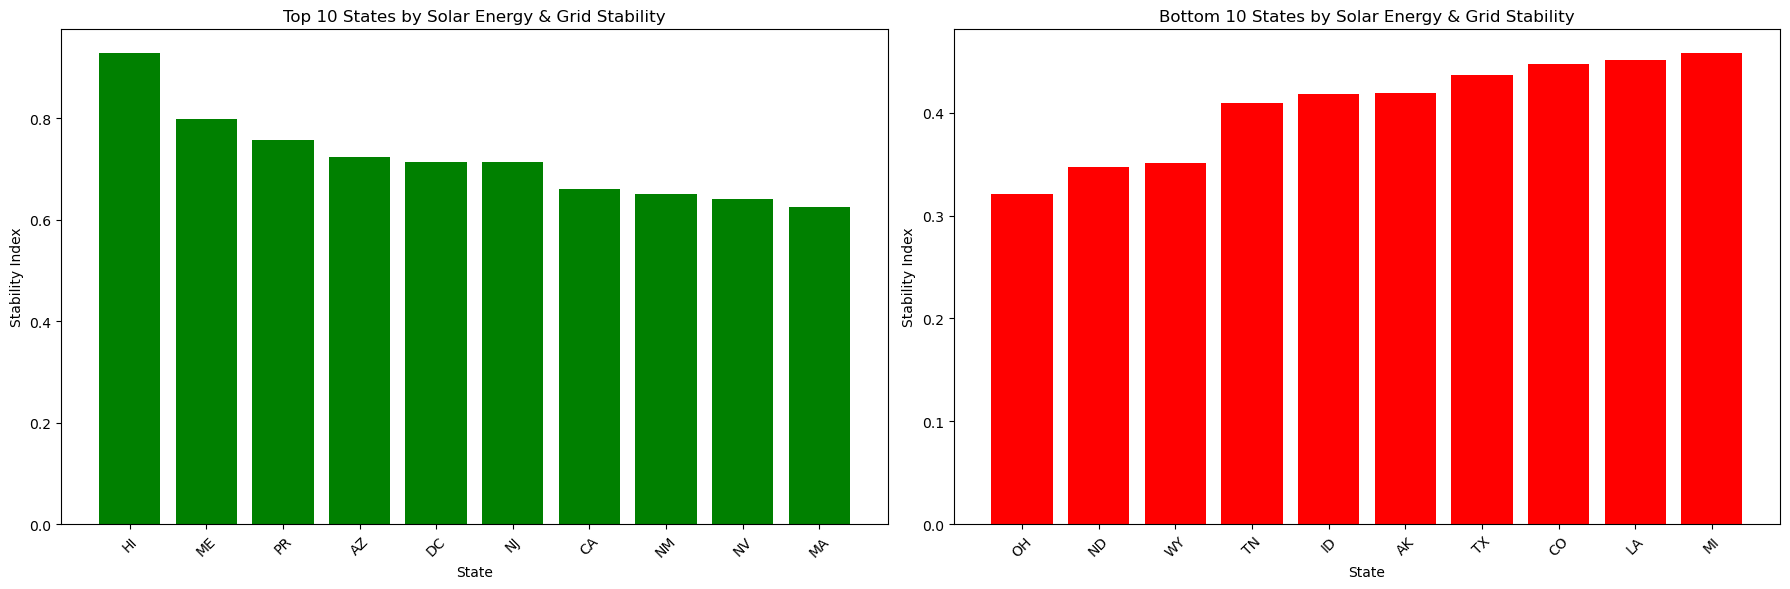

In [12]:
import matplotlib.pyplot as plt

# Get top 10 and bottom 10 states
top_states = merged_df.sort_values("index", ascending=False).head(10)
bottom_states = merged_df.sort_values("index", ascending=True).head(10)

# Create a figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 10 States
axes[0].bar(top_states["State"], top_states["index"], color='green')
axes[0].set_xlabel("State")
axes[0].set_ylabel("Stability Index")
axes[0].set_title("Top 10 States by Solar Energy & Grid Stability")
axes[0].set_xticklabels(top_states["State"], rotation=45)

# Bottom 10 States
axes[1].bar(bottom_states["State"], bottom_states["index"], color='red')
axes[1].set_xlabel("State")
axes[1].set_ylabel("Stability Index")
axes[1].set_title("Bottom 10 States by Solar Energy & Grid Stability")
axes[1].set_xticklabels(bottom_states["State"], rotation=45)

plt.tight_layout()
plt.show()


In [13]:
import plotly.express as px

fig = px.choropleth(
    merged_df,  
    locations='State',  
    locationmode='USA-states',  
    color='index',  
    scope='usa',  
    title='Energy & Grid Stability Index (index) by State',
    color_continuous_scale='Viridis'
)

fig.show()


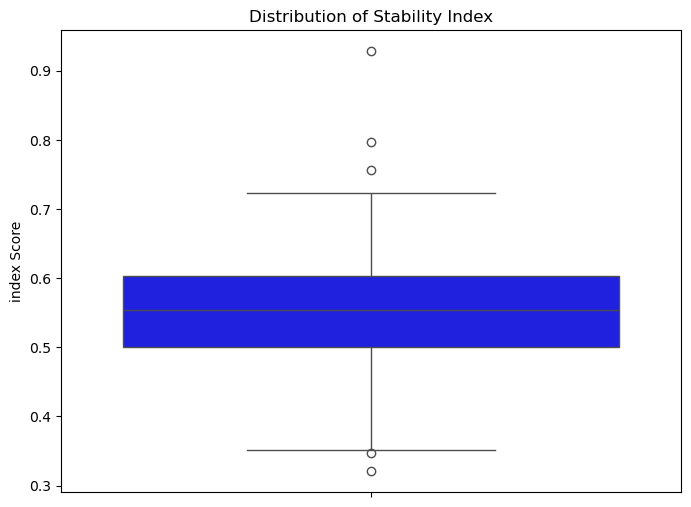

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(y=merged_df["index"], color="blue")
plt.title("Distribution of Stability Index")
plt.ylabel("index Score")
plt.show()


Shows spread and variability in index


/var/folders/2z/wq9630lx4dl17_8c406wvh7r0000gn/T/ipykernel_10388/1226384651.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




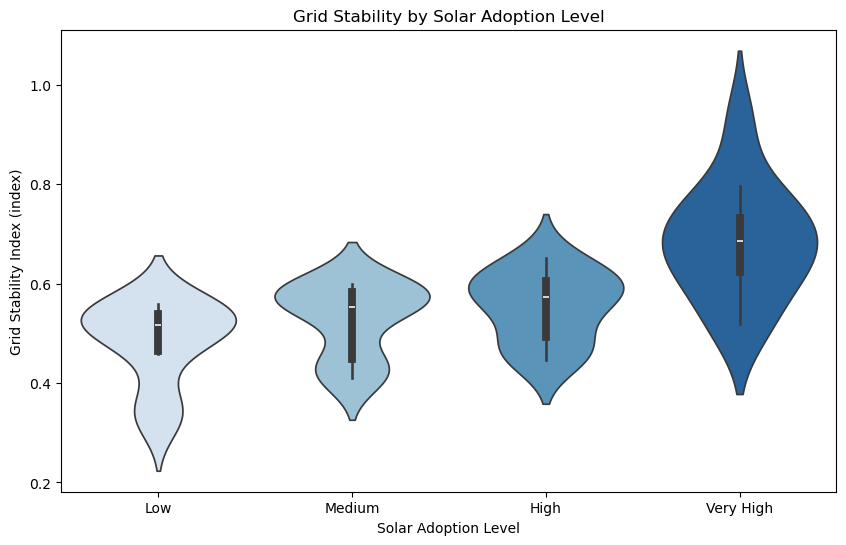

In [15]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=pd.qcut(merged_df["Solar_Adoption_Rate"], q=4, labels=["Low", "Medium", "High", "Very High"]),
               y=merged_df["index"], palette="Blues")
plt.xlabel("Solar Adoption Level")
plt.ylabel("Grid Stability Index (index)")
plt.title("Grid Stability by Solar Adoption Level")
plt.show()


This shows how the index is distributed among states with different levels of solar adoption.
This highlights whether higher solar adoption = more stable grid.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define x and y
X = merged_df[["Solar_Adoption_Rate", "Wildfire_Count", "Power_Outage_Count", "Emissions_Per_Capita", "Electricity_Rate"]]
y = merged_df["index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict index
y_pred = model.predict(X_test)

# Evaluate model
accuracy = mean_absolute_error(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.03724648526756664


MAE Range 0.00 - 0.05 = excellent prediction
0.05 - 0.10 = good prediction
0.10 - 0.20 = moderate 
above 0.20 = high error

0.0372 is excellent result

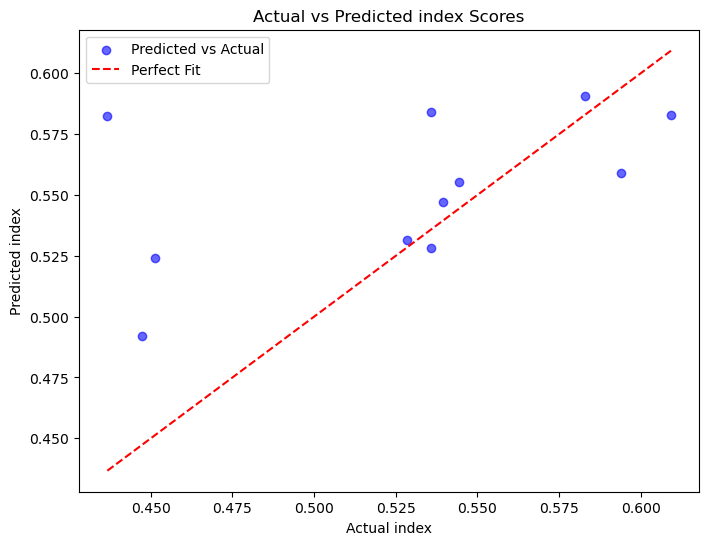

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Fit") 

# Labels and title
plt.xlabel("Actual index")
plt.ylabel("Predicted index")
plt.title("Actual vs Predicted index Scores")
plt.legend()
plt.show()

Scattor plot compares the actual index value with the predicted index value. Red line represents a perfect prediction, meaning if all blue dots were on the line, the model would be 100% accurate.

Most points are close to the red line, meaning model is doing a good job predicting the index.

Overall accuracy is good with only 0.0372 Mean Absolute Error. model's predictions are very close to the actual values. Model seems reliable.

- Scatter plot compares our model's predicted index scores against the actual scores.
- Since most points are close to the red line, our model is making accurate predictions with a low error rate of only 3.7%
- This means our model can successfuly estimate a state's energy grid stability, helpnig predict future trends


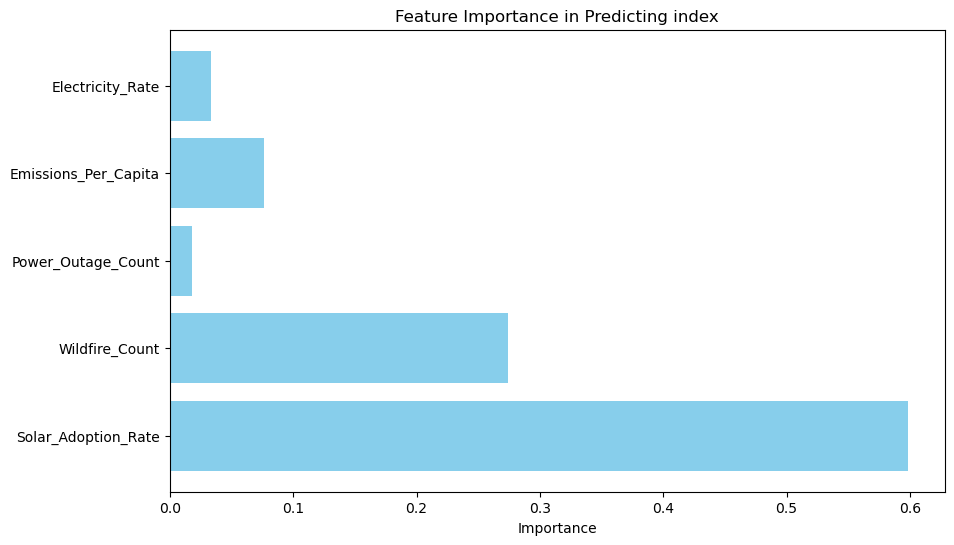

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Use feature importance
feature_importance = model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10,6))
plt.barh(features, feature_importance, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance in Predicting index")
plt.show()


This analyszes which factros contribute the most to the index
This helps to understand which policies will improve energy stability
